In [24]:
from fastai import *
from fastai.vision import *
from fastai.vision import image as im
import torch.nn as nn
from torchvision.models import mobilenet_v2
from torch.nn.functional import mse_loss
import json
import re

%matplotlib inline
plt.figure(figsize=(180,180))

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

<Figure size 12960x12960 with 0 Axes>

In [25]:
image_path = '/home/hanwei-1/data/hand_labels_synth/synth2_3'
json_path = '/home/hanwei-1/data/hand_labels_synth/synth2_json'

In [26]:
transforms = get_transforms(do_flip=False, max_zoom=1.05, max_warp=0.01,max_rotate=5, p_affine=1, p_lighting=1) 
# def get_y_func(x):
#      pre, ext = os.path.splitext(x)
#      img = open_image(x)
#      coords = []
#      for k in json.load(open(pre + '.json'))['hand_keypoints']:
#         coords.append([k[1],k[0]]) # inverting x and y
#      return torch.tensor(coords,dtype=torch.float)
def get_y_func(x):
    pre, ext = os.path.splitext(x)
    hand_data_out = []
    hand_return = []
#     pre = pre.replace('synth2','synth2_json')
    hand_data = json.load(open(pre + '.json'))
    for i in range(21):
        hand_tem_xy = hand_data['hand_pts'][i][:2]
        hand_tem_xy.reverse()
        hand_data_out.append(hand_tem_xy)
#     hand_return.append(hand_data_out[4])
#     hand_return.append(hand_data_out[8])
#     hand_return.append(hand_data_out[12])
#     hand_return.append(hand_data_out[16])
#     hand_return.append(hand_data_out[20])
#     print(hand_data_out,end='\r' )
    return Tensor(hand_data_out)

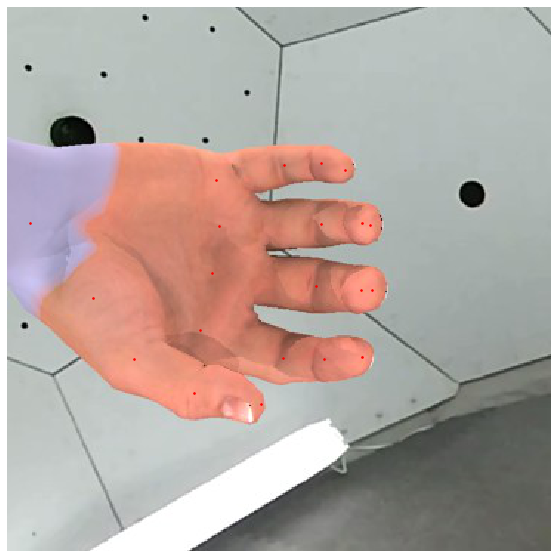

In [34]:
img_path = os.path.join(image_path, "00000050.jpg")
img = open_image(img_path)
points = ImagePoints(FlowField(img.size, get_y_func(img_path)))
img.show(y=points, figsize=(10, 10))

In [5]:
data = (PointsItemList.from_folder(path=image_path, presort=True)
        .split_by_rand_pct()
        .label_from_func(get_y_func, label_cls=PointsLabelList)
        .transform(transforms,size=(368,368), tfm_y=True, remove_out=False, 
                   padding_mode='border', resize_method=ResizeMethod.PAD)
        .databunch(bs=80)
        .normalize(imagenet_stats))

In [6]:
data

ImageDataBunch;

Train: LabelList (4473 items)
x: PointsItemList
Image (3, 368, 368),Image (3, 368, 368),Image (3, 368, 368),Image (3, 368, 368),Image (3, 368, 368)
y: PointsLabelList
ImagePoints (368, 368),ImagePoints (368, 368),ImagePoints (368, 368),ImagePoints (368, 368),ImagePoints (368, 368)
Path: /home/hanwei-1/data/hand_labels_synth/synth2_3;

Valid: LabelList (1118 items)
x: PointsItemList
Image (3, 368, 368),Image (3, 368, 368),Image (3, 368, 368),Image (3, 368, 368),Image (3, 368, 368)
y: PointsLabelList
ImagePoints (368, 368),ImagePoints (368, 368),ImagePoints (368, 368),ImagePoints (368, 368),ImagePoints (368, 368)
Path: /home/hanwei-1/data/hand_labels_synth/synth2_3;

Test: None

In [7]:
# data.show_batch(rows=10)

In [8]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [9]:
head_reg = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(247808, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 42),
    Reshape(-1,21,2),
    nn.Tanh()
    ) 

# head_reg = nn.Sequential(
#     Flatten(), 
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(73728, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Dropout(0.5),
#     nn.Linear(1024, 256),
#     nn.ReLU(),
#     nn.BatchNorm1d(256),
#     nn.Dropout(0.5),
#     nn.Linear(256, 10),
#     Reshape(-1,5,2),
#     nn.Tanh()) 

# head_reg = nn.Sequential(
#     nn.Conv2d(512,256,kernel_size =(1,1)),
#     nn.BatchNorm2d(256),
#     nn.ReLU(),
#     Flatten(),
#     nn.Linear(256*12*12,1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Dropout(0.5),
#     nn.Linear(1024, 256),
#     nn.ReLU(),
#     nn.BatchNorm1d(256),
#     nn.Linear(256,10),
#     Reshape(-1,5,2),
#     nn.Tanh()
#     ) 

# head_reg = nn.Sequential(
#     nn.AdaptiveAvgPool2d(1),
#     nn.AdaptiveMaxPool2d(1),
#     Flatten(),
#     nn.BatchNorm1d(512),
#     nn.Dropout(0.25),
#     nn.Linear(1024,512),
#     nn.ReLU(),
#     nn.BatchNorm1d(512),
#     nn.Dropout(0.25),
#     nn.Linear(512,42),
#     Reshape(-1,21,2),
#     ) 

In [10]:
class MSELossFlat(nn.MSELoss):
    def forward(self, input:Tensor, target:Tensor):
     return super().forward(input.view(-1), target.view(-1)) 

In [11]:
mse_loss_flat = MSELossFlat()  

In [12]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
torch.cuda.set_device(1)
learn = cnn_learner(data, models.squeezenet1_1,custom_head=head_reg, loss_func=mse_loss_flat)
learn.unfreeze()
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 183, 183]       1,792      True      
______________________________________________________________________
ReLU                 [64, 183, 183]       0          False     
______________________________________________________________________
MaxPool2d            [64, 91, 91]         0          False     
______________________________________________________________________
Conv2d               [16, 91, 91]         1,040      True      
______________________________________________________________________
ReLU                 [16, 91, 91]         0          False     
______________________________________________________________________
Conv2d               [64, 91, 91]         1,088      True      
______________________________________________________________________
ReLU                 [64, 91, 91]         0          False     
___________________________________________________

In [13]:
learn.fit_one_cycle(cyc_len = 200,max_lr = slice(1e-6,1e-2))

epoch,train_loss,valid_loss,time
0,0.333327,0.161134,00:17
1,0.251006,0.083104,00:16
2,0.166308,0.059991,00:15
3,0.106802,0.047199,00:16
4,0.076822,0.040806,00:15
5,0.059500,0.036574,00:15
6,0.053446,0.047057,00:15
7,0.048570,0.032282,00:16
8,0.041151,0.030750,00:16
9,0.033412,0.023876,00:16


In [14]:
learn.save("/home/hanwei-1/data/trained_model_21_point_mseloss_loss", return_path=True)
# learn.load("/home/hanwei-1/data/trained_model_5_point_mseloss_loss_0.019")

PosixPath('/home/hanwei-1/data/trained_model_21_point_mseloss_loss.pth')

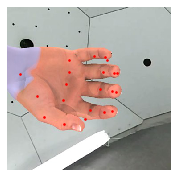

In [33]:
img = im.open_image('/home/hanwei-1/data/hand_labels_synth/synth2/00000050.jpg')
preds = learn.predict(img)
img.show(y=preds[0])

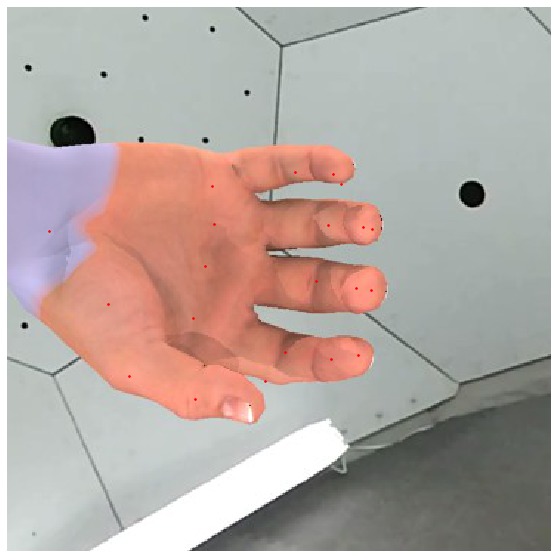

In [41]:
img = im.open_image('/home/hanwei-1/data/hand_labels_synth/synth2/00000050.jpg')
preds = learn.predict(img)
preds= preds[1]+torch.ones(21,2) # denormalizing
preds=torch.mm(preds,torch.tensor([[img.size[0]/2,0],
[0,img.size[1]/2]],dtype=torch.float))
preds = ImagePoints(FlowField([6000,6000], preds),)
img.show(y=preds, figsize=(10, 10))

In [ ]:
# learn.lr_find(end_lr=100)
# learn.recorder.plot()

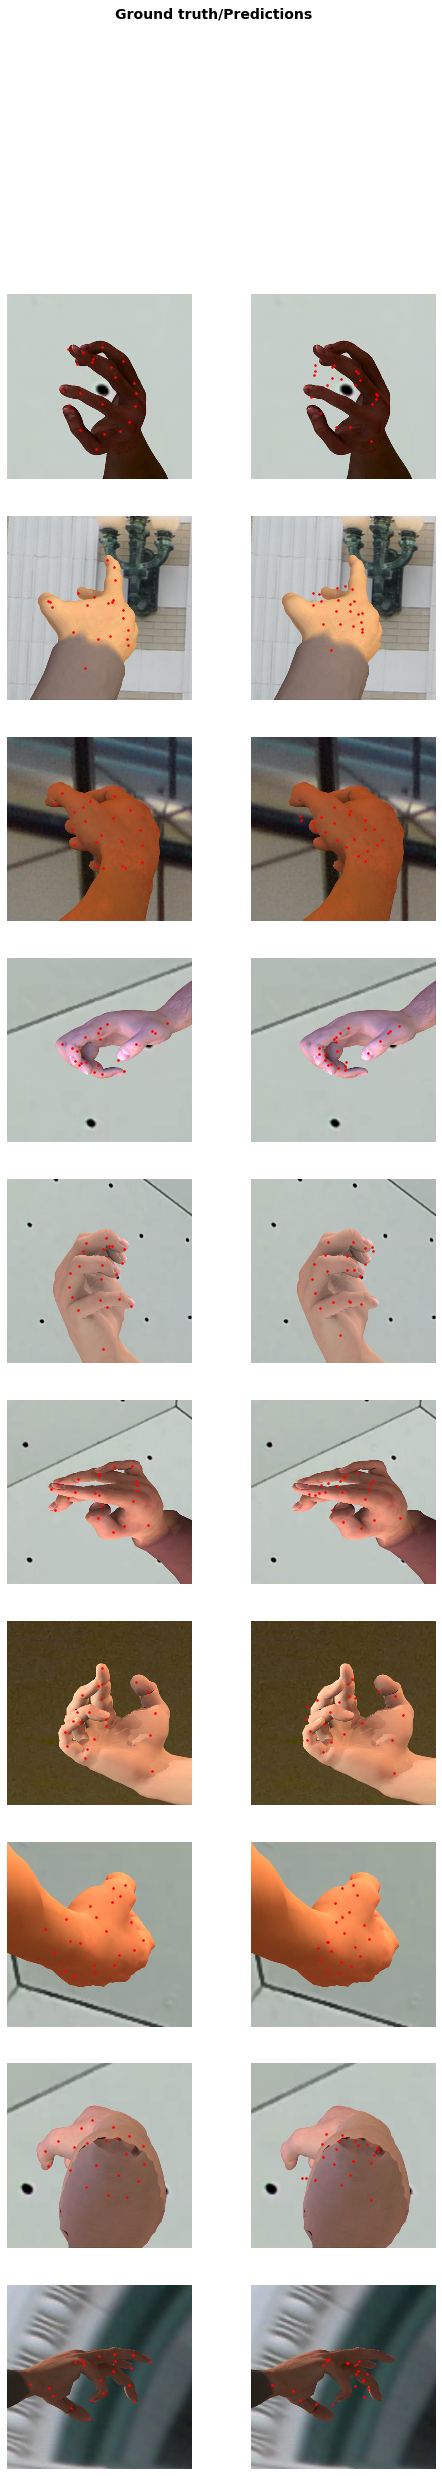

In [19]:
learn.show_results(rows=10)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


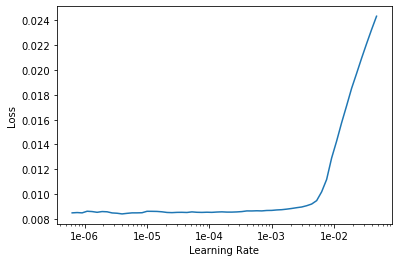

In [22]:
learn.recorder.plot()

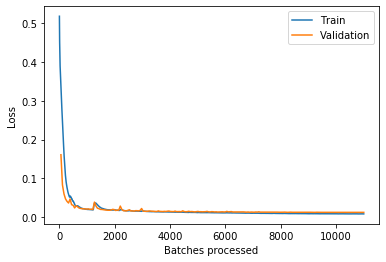

In [20]:
learn.recorder.plot_losses()